# Question 2 - Getting Started

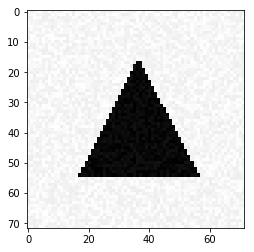

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# Question 3 - Simple Classification

In [26]:
#Imports
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD, Adam
from keras.utils import np_utils

In [27]:
# Generating Training Data
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_valid, Y_valid] = generate_dataset_classification(60, 20)
Y_train = np_utils.to_categorical(Y_train)
Y_valid = np_utils.to_categorical(Y_valid)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50


##  Stochastic gradient descent optimizer

In [30]:
# Defining the Network
nb_neurons = 3
model_sgd = Sequential()
model_sgd.add(Dense(nb_neurons, activation='softmax', input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
    
# Defining the Optimization Method
sgd = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
model_sgd.compile(loss='categorical_crossentropy', optimizer=sgd)

# Running the Optimization
model_sgd.fit(X_train, Y_train, epochs=1000, batch_size=32, validation_data=(X_valid, Y_valid))

Train on 300 samples, validate on 60 samples
Epoch 1/1000
300/300 [==============================] - 0s - loss: 1.1519 - val_loss: 1.0302
Epoch 2/1000
300/300 [==============================] - 0s - loss: 1.0050 - val_loss: 1.2752
Epoch 3/1000
300/300 [==============================] - 0s - loss: 0.9370 - val_loss: 1.1236
Epoch 4/1000
300/300 [==============================] - 0s - loss: 0.8880 - val_loss: 0.8383
Epoch 5/1000
300/300 [==============================] - 0s - loss: 0.8016 - val_loss: 0.7509
Epoch 6/1000
300/300 [==============================] - 0s - loss: 0.7289 - val_loss: 0.8836
Epoch 7/1000
300/300 [==============================] - 0s - loss: 0.7507 - val_loss: 0.6748
Epoch 8/1000
300/300 [==============================] - 0s - loss: 0.6834 - val_loss: 0.6849
Epoch 9/1000
300/300 [==============================] - 0s - loss: 0.6529 - val_loss: 0.8365
Epoch 10/1000
300/300 [==============================] - 0s - loss: 0.6473 - val_loss: 0.7821
Epoch 11/1000
300/300 [=

300/300 [==============================] - 0s - loss: 0.2110 - val_loss: 0.2166
Epoch 88/1000
300/300 [==============================] - 0s - loss: 0.2108 - val_loss: 0.2228
Epoch 89/1000
300/300 [==============================] - 0s - loss: 0.2160 - val_loss: 0.2268
Epoch 90/1000
300/300 [==============================] - 0s - loss: 0.2107 - val_loss: 0.2141
Epoch 91/1000
300/300 [==============================] - 0s - loss: 0.2100 - val_loss: 0.2110
Epoch 92/1000
300/300 [==============================] - 0s - loss: 0.2056 - val_loss: 0.2214
Epoch 93/1000
300/300 [==============================] - 0s - loss: 0.2030 - val_loss: 0.2276
Epoch 94/1000
300/300 [==============================] - 0s - loss: 0.2055 - val_loss: 0.2082
Epoch 95/1000
300/300 [==============================] - 0s - loss: 0.2007 - val_loss: 0.2064
Epoch 96/1000
300/300 [==============================] - 0s - loss: 0.2074 - val_loss: 0.2230
Epoch 97/1000
300/300 [==============================] - 0s - loss: 0.1990

300/300 [==============================] - 0s - loss: 0.1327 - val_loss: 0.1395
Epoch 174/1000
300/300 [==============================] - 0s - loss: 0.1348 - val_loss: 0.1416
Epoch 175/1000
300/300 [==============================] - 0s - loss: 0.1321 - val_loss: 0.1362
Epoch 176/1000
300/300 [==============================] - 0s - loss: 0.1329 - val_loss: 0.1344
Epoch 177/1000
300/300 [==============================] - 0s - loss: 0.1331 - val_loss: 0.1460
Epoch 178/1000
300/300 [==============================] - 0s - loss: 0.1334 - val_loss: 0.1327
Epoch 179/1000
300/300 [==============================] - 0s - loss: 0.1297 - val_loss: 0.1336
Epoch 180/1000
300/300 [==============================] - 0s - loss: 0.1300 - val_loss: 0.1317
Epoch 181/1000
300/300 [==============================] - 0s - loss: 0.1334 - val_loss: 0.1305
Epoch 182/1000
300/300 [==============================] - 0s - loss: 0.1302 - val_loss: 0.1363
Epoch 183/1000
300/300 [==============================] - 0s - lo

300/300 [==============================] - 0s - loss: 0.0962 - val_loss: 0.1075
Epoch 260/1000
300/300 [==============================] - 0s - loss: 0.0967 - val_loss: 0.0994
Epoch 261/1000
300/300 [==============================] - 0s - loss: 0.0985 - val_loss: 0.1061
Epoch 262/1000
300/300 [==============================] - 0s - loss: 0.0974 - val_loss: 0.0997
Epoch 263/1000
300/300 [==============================] - 0s - loss: 0.0976 - val_loss: 0.1080
Epoch 264/1000
300/300 [==============================] - 0s - loss: 0.0956 - val_loss: 0.0977
Epoch 265/1000
300/300 [==============================] - 0s - loss: 0.0979 - val_loss: 0.0980
Epoch 266/1000
300/300 [==============================] - 0s - loss: 0.0961 - val_loss: 0.0994
Epoch 267/1000
300/300 [==============================] - 0s - loss: 0.0977 - val_loss: 0.0980
Epoch 268/1000
300/300 [==============================] - 0s - loss: 0.0969 - val_loss: 0.0967
Epoch 269/1000
300/300 [==============================] - 0s - lo

300/300 [==============================] - 0s - loss: 0.0786 - val_loss: 0.0784
Epoch 346/1000
300/300 [==============================] - 0s - loss: 0.0786 - val_loss: 0.0821
Epoch 347/1000
300/300 [==============================] - 0s - loss: 0.0773 - val_loss: 0.0797
Epoch 348/1000
300/300 [==============================] - 0s - loss: 0.0782 - val_loss: 0.0842
Epoch 349/1000
300/300 [==============================] - 0s - loss: 0.0783 - val_loss: 0.0826
Epoch 350/1000
300/300 [==============================] - 0s - loss: 0.0763 - val_loss: 0.0776
Epoch 351/1000
300/300 [==============================] - 0s - loss: 0.0768 - val_loss: 0.0773
Epoch 352/1000
300/300 [==============================] - 0s - loss: 0.0759 - val_loss: 0.0780
Epoch 353/1000
300/300 [==============================] - 0s - loss: 0.0748 - val_loss: 0.0806
Epoch 354/1000
300/300 [==============================] - 0s - loss: 0.0781 - val_loss: 0.0814
Epoch 355/1000
300/300 [==============================] - 0s - lo

300/300 [==============================] - 0s - loss: 0.0652 - val_loss: 0.0665
Epoch 432/1000
300/300 [==============================] - 0s - loss: 0.0638 - val_loss: 0.0700
Epoch 433/1000
300/300 [==============================] - 0s - loss: 0.0637 - val_loss: 0.0657
Epoch 434/1000
300/300 [==============================] - 0s - loss: 0.0641 - val_loss: 0.0663
Epoch 435/1000
300/300 [==============================] - 0s - loss: 0.0634 - val_loss: 0.0648
Epoch 436/1000
300/300 [==============================] - 0s - loss: 0.0636 - val_loss: 0.0671
Epoch 437/1000
300/300 [==============================] - 0s - loss: 0.0632 - val_loss: 0.0661
Epoch 438/1000
300/300 [==============================] - 0s - loss: 0.0631 - val_loss: 0.0654
Epoch 439/1000
300/300 [==============================] - 0s - loss: 0.0626 - val_loss: 0.0654
Epoch 440/1000
300/300 [==============================] - 0s - loss: 0.0624 - val_loss: 0.0664
Epoch 441/1000
300/300 [==============================] - 0s - lo

300/300 [==============================] - 0s - loss: 0.0550 - val_loss: 0.0560
Epoch 518/1000
300/300 [==============================] - 0s - loss: 0.0542 - val_loss: 0.0553
Epoch 519/1000
300/300 [==============================] - 0s - loss: 0.0545 - val_loss: 0.0553
Epoch 520/1000
300/300 [==============================] - 0s - loss: 0.0546 - val_loss: 0.0563
Epoch 521/1000
300/300 [==============================] - 0s - loss: 0.0546 - val_loss: 0.0614
Epoch 522/1000
300/300 [==============================] - 0s - loss: 0.0539 - val_loss: 0.0549
Epoch 523/1000
300/300 [==============================] - 0s - loss: 0.0545 - val_loss: 0.0571
Epoch 524/1000
300/300 [==============================] - 0s - loss: 0.0540 - val_loss: 0.0567
Epoch 525/1000
300/300 [==============================] - 0s - loss: 0.0542 - val_loss: 0.0582
Epoch 526/1000
300/300 [==============================] - 0s - loss: 0.0539 - val_loss: 0.0572
Epoch 527/1000
300/300 [==============================] - 0s - lo

300/300 [==============================] - 0s - loss: 0.0483 - val_loss: 0.0485
Epoch 604/1000
300/300 [==============================] - 0s - loss: 0.0474 - val_loss: 0.0500
Epoch 605/1000
300/300 [==============================] - 0s - loss: 0.0472 - val_loss: 0.0484
Epoch 606/1000
300/300 [==============================] - 0s - loss: 0.0472 - val_loss: 0.0493
Epoch 607/1000
300/300 [==============================] - 0s - loss: 0.0470 - val_loss: 0.0491
Epoch 608/1000
300/300 [==============================] - 0s - loss: 0.0469 - val_loss: 0.0487
Epoch 609/1000
300/300 [==============================] - 0s - loss: 0.0469 - val_loss: 0.0481
Epoch 610/1000
300/300 [==============================] - 0s - loss: 0.0474 - val_loss: 0.0484
Epoch 611/1000
300/300 [==============================] - 0s - loss: 0.0470 - val_loss: 0.0485
Epoch 612/1000
300/300 [==============================] - 0s - loss: 0.0466 - val_loss: 0.0481
Epoch 613/1000
300/300 [==============================] - 0s - lo

300/300 [==============================] - 0s - loss: 0.0417 - val_loss: 0.0433
Epoch 690/1000
300/300 [==============================] - 0s - loss: 0.0419 - val_loss: 0.0431
Epoch 691/1000
300/300 [==============================] - 0s - loss: 0.0426 - val_loss: 0.0431
Epoch 692/1000
300/300 [==============================] - 0s - loss: 0.0416 - val_loss: 0.0432
Epoch 693/1000
300/300 [==============================] - 0s - loss: 0.0413 - val_loss: 0.0428
Epoch 694/1000
300/300 [==============================] - 0s - loss: 0.0418 - val_loss: 0.0447
Epoch 695/1000
300/300 [==============================] - 0s - loss: 0.0419 - val_loss: 0.0431
Epoch 696/1000
300/300 [==============================] - 0s - loss: 0.0417 - val_loss: 0.0431
Epoch 697/1000
300/300 [==============================] - 0s - loss: 0.0415 - val_loss: 0.0446
Epoch 698/1000
300/300 [==============================] - 0s - loss: 0.0415 - val_loss: 0.0429
Epoch 699/1000
300/300 [==============================] - 0s - lo

300/300 [==============================] - 0s - loss: 0.0373 - val_loss: 0.0386
Epoch 776/1000
300/300 [==============================] - 0s - loss: 0.0373 - val_loss: 0.0391
Epoch 777/1000
300/300 [==============================] - 0s - loss: 0.0371 - val_loss: 0.0402
Epoch 778/1000
300/300 [==============================] - 0s - loss: 0.0373 - val_loss: 0.0387
Epoch 779/1000
300/300 [==============================] - 0s - loss: 0.0371 - val_loss: 0.0393
Epoch 780/1000
300/300 [==============================] - 0s - loss: 0.0376 - val_loss: 0.0389
Epoch 781/1000
300/300 [==============================] - 0s - loss: 0.0368 - val_loss: 0.0384
Epoch 782/1000
300/300 [==============================] - 0s - loss: 0.0370 - val_loss: 0.0385
Epoch 783/1000
300/300 [==============================] - 0s - loss: 0.0368 - val_loss: 0.0386
Epoch 784/1000
300/300 [==============================] - 0s - loss: 0.0367 - val_loss: 0.0382
Epoch 785/1000
300/300 [==============================] - 0s - lo

300/300 [==============================] - 0s - loss: 0.0337 - val_loss: 0.0350
Epoch 862/1000
300/300 [==============================] - 0s - loss: 0.0337 - val_loss: 0.0361
Epoch 863/1000
300/300 [==============================] - 0s - loss: 0.0336 - val_loss: 0.0352
Epoch 864/1000
300/300 [==============================] - 0s - loss: 0.0335 - val_loss: 0.0348
Epoch 865/1000
300/300 [==============================] - 0s - loss: 0.0339 - val_loss: 0.0350
Epoch 866/1000
300/300 [==============================] - 0s - loss: 0.0335 - val_loss: 0.0349
Epoch 867/1000
300/300 [==============================] - 0s - loss: 0.0338 - val_loss: 0.0348
Epoch 868/1000
300/300 [==============================] - 0s - loss: 0.0335 - val_loss: 0.0349
Epoch 869/1000
300/300 [==============================] - 0s - loss: 0.0333 - val_loss: 0.0349
Epoch 870/1000
300/300 [==============================] - 0s - loss: 0.0334 - val_loss: 0.0346
Epoch 871/1000
300/300 [==============================] - 0s - lo

300/300 [==============================] - 0s - loss: 0.0310 - val_loss: 0.0323
Epoch 948/1000
300/300 [==============================] - 0s - loss: 0.0308 - val_loss: 0.0322
Epoch 949/1000
300/300 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0322
Epoch 950/1000
300/300 [==============================] - 0s - loss: 0.0306 - val_loss: 0.0326
Epoch 951/1000
300/300 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0321
Epoch 952/1000
300/300 [==============================] - 0s - loss: 0.0304 - val_loss: 0.0319
Epoch 953/1000
300/300 [==============================] - 0s - loss: 0.0307 - val_loss: 0.0320
Epoch 954/1000
300/300 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0318
Epoch 955/1000
300/300 [==============================] - 0s - loss: 0.0304 - val_loss: 0.0331
Epoch 956/1000
300/300 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0319
Epoch 957/1000
300/300 [==============================] - 0s - lo

## Adam optimizer

In [32]:
# Defining the Network
nb_neurons = 3
model_adam = Sequential()
model_adam.add(Dense(nb_neurons, activation='softmax', input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
    
# Defining the Optimization Method
model_adam.compile(loss='categorical_crossentropy', optimizer=Adam(0.001))

# Running the Optimization
model_adam.fit(X_train, Y_train, epochs=1000, batch_size=32, validation_data=(X_valid, Y_valid))

Train on 300 samples, validate on 60 samples
Epoch 1/100
300/300 [==============================] - 0s - loss: 1.9336 - val_loss: 1.9025
Epoch 2/100
300/300 [==============================] - 0s - loss: 1.0836 - val_loss: 0.9365
Epoch 3/100
300/300 [==============================] - 0s - loss: 0.6092 - val_loss: 0.5283
Epoch 4/100
300/300 [==============================] - 0s - loss: 0.4339 - val_loss: 0.4209
Epoch 5/100
300/300 [==============================] - 0s - loss: 0.4716 - val_loss: 0.3501
Epoch 6/100
300/300 [==============================] - 0s - loss: 0.3886 - val_loss: 0.3112
Epoch 7/100
300/300 [==============================] - 0s - loss: 0.2746 - val_loss: 0.2624
Epoch 8/100
300/300 [==============================] - 0s - loss: 0.2624 - val_loss: 0.2758
Epoch 9/100
300/300 [==============================] - 0s - loss: 0.2235 - val_loss: 0.2095
Epoch 10/100
300/300 [==============================] - 0s - loss: 0.2120 - val_loss: 0.2044
Epoch 11/100
300/300 [============

300/300 [==============================] - 0s - loss: 0.0100 - val_loss: 0.0110
Epoch 89/100
300/300 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0109
Epoch 90/100
300/300 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0108
Epoch 91/100
300/300 [==============================] - 0s - loss: 0.0103 - val_loss: 0.0133
Epoch 92/100
300/300 [==============================] - 0s - loss: 0.0107 - val_loss: 0.0106
Epoch 93/100
300/300 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0112
Epoch 94/100
300/300 [==============================] - 0s - loss: 0.0102 - val_loss: 0.0114
Epoch 95/100
300/300 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0097
Epoch 96/100
300/300 [==============================] - 0s - loss: 0.0087 - val_loss: 0.0099
Epoch 97/100
300/300 [==============================] - 0s - loss: 0.0084 - val_loss: 0.0095
Epoch 98/100
300/300 [==============================] - 0s - loss: 0.0083 - val_los

# Question 4 - Visualization of the Solution


In [36]:
def visualize_column(model):
    weights = model.get_weights()[0]
    weights = weights.reshape(IMAGE_SIZE, IMAGE_SIZE, weights.shape[1])
    _, [ax0, ax1, ax2] = plt.subplots(1, 3)
    ax0.imshow(weights[:,:,0], cmap='gray')
    ax1.imshow(weights[:,:,1], cmap='gray')
    ax2.imshow(weights[:,:,2], cmap='gray')



## Stochastic gradient descent optimizer

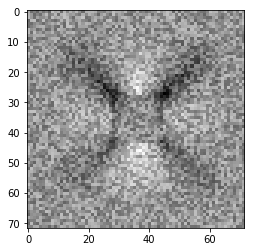

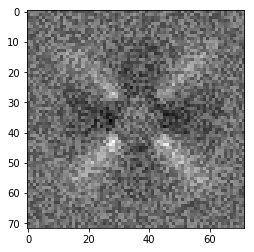

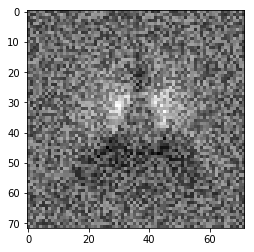

In [41]:
visualize_column(model_sgd)

## Adam optimizer

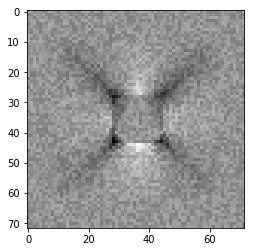

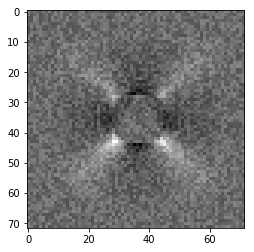

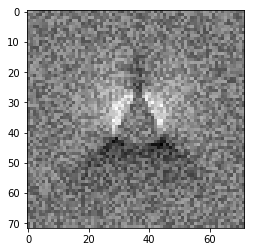

In [42]:
visualize_column(model_adam)

# Question 5 - A More Difficult Classification Problem